In [23]:
import random

class state:
    MIN_X_POSITION = -10
    MAX_X_POSITION = 10

    def __init__(self, x_position: float = None): 
        if x_position:
            self.x_position = x_position 
        else:
            self.x_position = random.uniform(self.MIN_X_POSITION, self.MAX_X_POSITION)
    
    def get_potential_energy(self) -> float:
        '''
        U(x) = x^2
        Returns the potential energy of the state
        '''
        return self.x_position ** 2
    

In [24]:
import math

def monte_carlo_algorithm(start_after: int = 10, iterations: int = 1_000_000, initial_state: state = None) -> list[state]:
    '''
    Naive implementation without a convergence check, just goes for a fixed number of iterations
    Psuedo code:
        1. Initialize any state X(0)
        2. Propose a new state X(1)
        3. Compute energy difference: E(X(1)) - E(X(0))
        
        if dE < 0:
            accept X(1)
        else:
            accept X(1) with probability exp(-dE / kT)
        
        4. Iterate until convergence
    
    Returns a list of distribution of states
    '''
    
    KT = 1
    
    current_state = initial_state if initial_state else state()
    state_history = []
    
    for i in range(iterations):
        proposed = state()
        energy_difference = proposed.get_potential_energy() - current_state.get_potential_energy()
        
        if energy_difference < 0 or random.random() < math.exp(-energy_difference / KT):
            current_state = proposed
            
        if i > start_after:
            state_history.append(current_state)
    
    return state_history

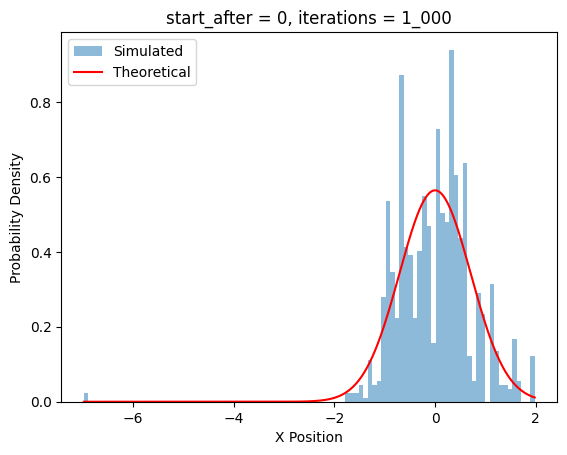

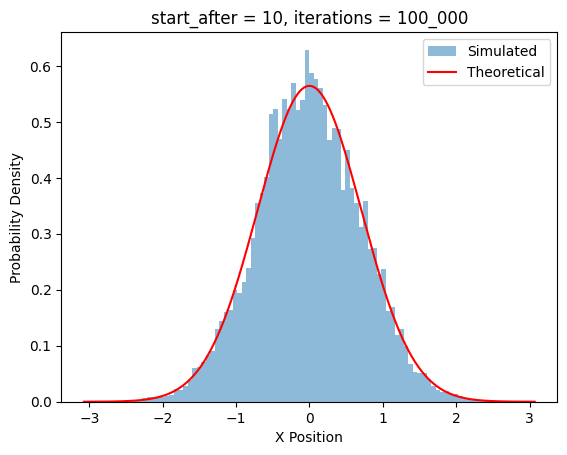

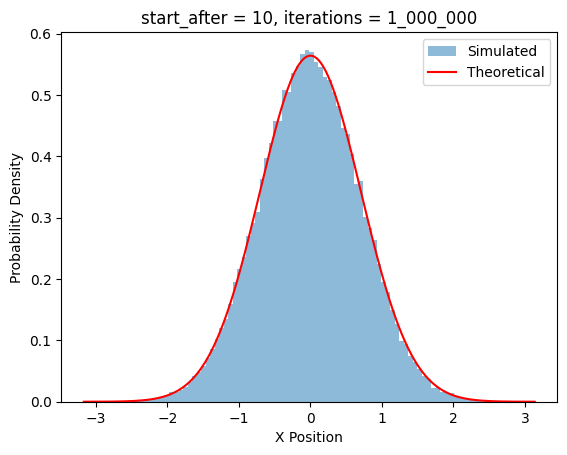

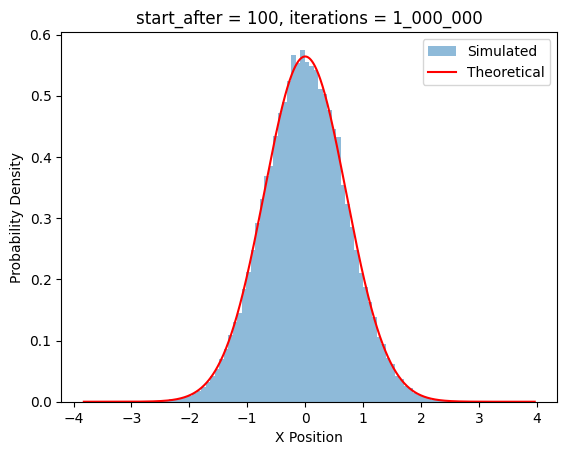

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math

def theoretical_probability_density(x, KT=1):
    norm_factor = 1 / np.pi ** 0.5
    return norm_factor * np.exp(-x ** 2 / KT)

def plot_state_history(state_history: list, title: str = None, KT=1) -> None:
    x_positions = [state.x_position for state in state_history]

    plt.hist(x_positions, bins=100, density=True, alpha=0.5, label='Simulated')

    x_range = np.linspace(min(x_positions), max(x_positions), 1000)
    y_theoretical = [theoretical_probability_density(x, KT) for x in x_range]
    plt.plot(x_range, y_theoretical, color='red', label='Theoretical')

    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

state_history_1 = monte_carlo_algorithm(start_after = 0, iterations = 1_000)
state_history_2 = monte_carlo_algorithm(start_after = 10, iterations = 100_000)
state_history_3 = monte_carlo_algorithm(start_after = 10, iterations = 1_000_000)
state_history_4 = monte_carlo_algorithm(start_after = 100, iterations = 1_000_000)

plot_state_history(state_history_1, title = 'start_after = 0, iterations = 1_000')
plot_state_history(state_history_2, title = 'start_after = 10, iterations = 100_000')
plot_state_history(state_history_3, title = 'start_after = 10, iterations = 1_000_000')
plot_state_history(state_history_4, title = 'start_after = 100, iterations = 1_000_000')

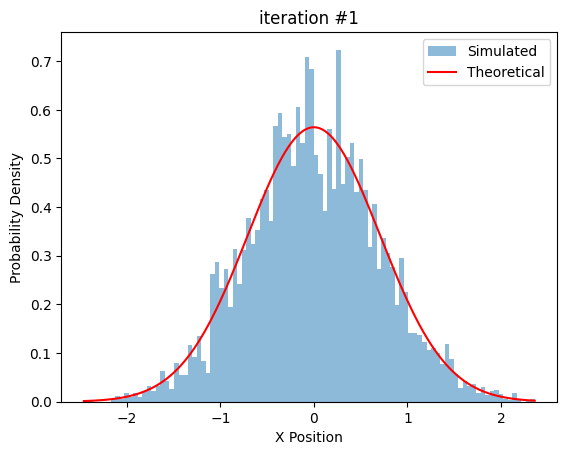

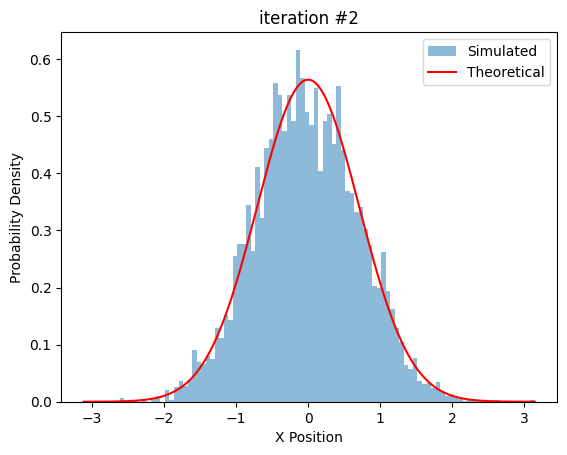

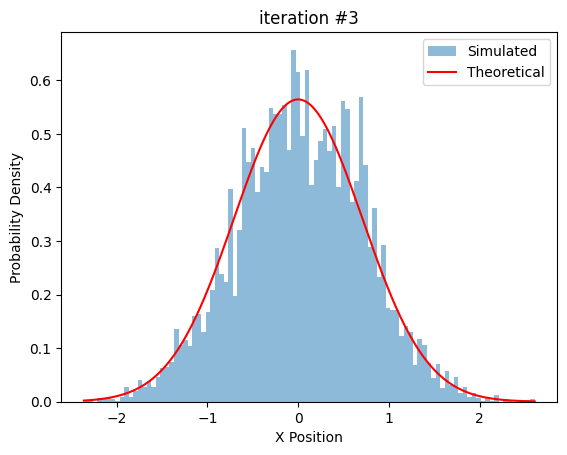

In [29]:
import math
import numpy as np
from typing import Callable

def custom_convergence_criterion(state_history1: list[state], state_history2: list[state]) -> bool:
    '''
    KL divergence between the two distributions
    '''

    MAX_ALLOWABLE_ERROR = 0.045
    
    a = np.array([state.x_position for state in state_history1])
    b = np.array([state.x_position for state in state_history2])
    
    min_x_position, max_x_position = -1.5, 1.5
    
    bins = np.linspace(min_x_position, max_x_position, 100)
    
    p_a = np.histogram(a, bins = bins)[0] / len(a)
    p_b = np.histogram(b, bins = bins)[0] / len(b)

    KL = np.sum(p_a * np.log(p_a / p_b))
    
    # print(KL)
    
    return KL < MAX_ALLOWABLE_ERROR
    
def monte_carlo_algorithm_with_convergence(convergence_criterion: Callable[[state, state], bool]) -> list[state]:
    '''
    Same as monte_carlo_algorithm, but with a convergence check
    '''
    
    current_state_history = monte_carlo_algorithm(start_after = 10, iterations = 30_000, initial_state = state())
    
    for i in range(100):
        plot_state_history(current_state_history, title = f'iteration #{i + 1}')
        last_state = current_state_history[-1]
        new_state_history = monte_carlo_algorithm(start_after = 10, iterations = 30_000, initial_state = last_state)
        
        if convergence_criterion(current_state_history, new_state_history):
            return new_state_history
        
        current_state_history = new_state_history
    
    # took too long to converge, return the last state history
    return current_state_history   
    
state_history = monte_carlo_algorithm_with_convergence(custom_convergence_criterion)